## Reminder
### Black-Scholes formula

$$
V^{\text{call}} = S\Phi(d_1) - e^{-r(T-t)}K\Phi(d_2), \quad
V^{\text{put}} = e^{-r(T-t)} K\Phi(-d_2) -S\Phi(-d_1),
$$
where $\Phi(x)$ is the standard normal cumulative distribution function, and
$$
d_1 = \frac{1}{\sigma\sqrt{(T - t)}} \biggl(\ln\frac{S}{K} 
  + \biggl(r+\frac{\sigma^2}{2}\biggr) (T - t)\biggr), \qquad 
d_2 = \frac{1}{\sigma\sqrt{(T - t)}} \biggl(\ln\frac{S}{K} 
  + \biggl(r-\frac{\sigma^2}{2}\biggr) (T - t)\biggr).
$$
**Note**: the option price is monotone as a function of $\sigma$.
We can invert the Black-Scholes formula to obtain
$$
\sigma^{IV} = V^{-1}(p),
$$
where $p$ is the observed market price.

### Greeks

Delta 
$$\Delta^{call} = \displaystyle \frac{\partial V^{call}}{\partial S} = \Phi(d_1)$$
$$\Delta^{put} = \displaystyle \frac{\partial V^{put}}{\partial S} = -\Phi(-d_1) = \Phi(d_1) - 1$$

Gamma
$$
\Gamma = \displaystyle\frac{\partial^{2} V}{\partial S^{2}} = \frac{\Phi'(d_1)}{S\sigma\sqrt{T - t}}
$$

Vega
$$
\mathcal{V} = \displaystyle \frac{\partial V}{\partial \sigma} = S \Phi'(d_1) \sqrt{T-t}
$$

Theta
$$
\theta^{call} = \displaystyle \frac{\partial V^{call}}{\partial t} = 
\frac{S \Phi'(d_1) \sigma}{2 \sqrt{T - t}} - rKe^{-r(T - t)}\Phi(d_2)
$$
$$
\theta^{put} = \displaystyle \frac{\partial V^{put}}{\partial t} =
\frac{S \Phi'(d_1) \sigma}{2 \sqrt{T - t}} + rKe^{-r(T - t)}\Phi(-d_2)
$$

Rho
$$
\rho^{call} = \displaystyle \frac{\partial V^{call}}{\partial r} = 
K(T - t)e^{-r(T - t)}\Phi( d_2)
$$
$$
\rho^{put} = \displaystyle \frac{\partial V^{put}}{\partial r} =
-K(T - t)e^{-r(T - t)}\Phi(-d_2)
$$

In [1]:
from typing import Union, Optional, Callable
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
from scipy import stats  
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from ipywidgets import interact
from ipywidgets import widgets
from tqdm.auto import tqdm

In [2]:
FloatArray = npt.NDArray[np.float64]
Floats = Union[float, FloatArray]   # то есть либо число float, либо массив float'ов

In [3]:
# Разделение по классам из следующих соображений:
# 1-й класс - это те параметры, которые мы можем извлечь прямо сейчас: 
# это состояние рынка, которое мы видим
# 2-й класс: параметры нашего опциона - мы их видим
# 3-й класс: параметр модели Б-Ш - волатильность, мы её не  знаем
 
@dataclass       #dataclass позволяет не писать init для класса и тд, аннотации типов в dataclass - обязательны
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]]
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)    

@dataclass
class BSParams:
    volatility: Floats

## The formulas

In [4]:
# dt = (T-t)
# из формулы выше - на dt накладываюся ограничение dt>0
# обходим след.образом: если dt очень маленькое - вместро него пишем некоторое eps (10e-14)

def dt(option: StockOption, ms: MarketState):
    return np.maximum(option.expiration_time - ms.time, np.finfo(np.float64).eps)


def d1(option: StockOption, ms: MarketState, params: BSParams):
    return 1 / (params.volatility * np.sqrt(dt(option, ms)))\
                * (np.log(ms.stock_price / option.strike_price)
                   + (ms.interest_rate + params.volatility ** 2 / 2) * dt(option, ms))


def d2(option: StockOption, ms: MarketState, params: BSParams):
    return d1(option, ms, params) - params.volatility * np.sqrt(dt(option, ms))

In [5]:
def price(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))
    
    call_price = stats.norm.cdf(d1(option, ms, params)) * ms.stock_price\
            - stats.norm.cdf(d2(option, ms, params)) * option.strike_price * discount_factor
    put_price = stats.norm.cdf(-d2(option, ms, params)) * option.strike_price * discount_factor\
        - stats.norm.cdf(-d1(option, ms, params)) * ms.stock_price
    
    return np.where(option.is_call, call_price, put_price)

In [6]:
def delta(option: StockOption, ms: MarketState, params: BSParams):
    nd1 = stats.norm.cdf(d1(option, ms, params))
    return np.where(option.is_call, nd1, nd1 - 1)


def gamma(option: StockOption, ms: MarketState, params: BSParams):
    return stats.norm.pdf(d1(option, ms, params)) / (ms.stock_price * params.volatility * np.sqrt(dt(option, ms)))


def theta(option: StockOption, ms: MarketState, params: BSParams):
    a = -ms.stock_price * stats.norm.pdf(d1(option, ms, params)) * params.volatility\
        / (2 * np.sqrt(dt(option, ms)))
    d_discount_factor = ms.interest_rate * np.exp(-ms.interest_rate * (dt(option, ms)))

    call_theta = a - option.strike_price * d_discount_factor * stats.norm.cdf(d2(option, ms, params))
    put_theta = a + option.strike_price * d_discount_factor * stats.norm.cdf(-d2(option, ms, params))
    return np.where(option.is_call, call_theta, put_theta)


def vega(option: StockOption, ms: MarketState, params: BSParams):
    return ms.stock_price * stats.norm.pdf(d1(option, ms, params)) * np.sqrt(dt(option, ms))


def rho(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))
    call_rho = option.strike_price * dt(option, ms) * discount_factor * stats.norm.cdf(d2(option, ms, params))
    put_rho = -option.strike_price * dt(option, ms) * discount_factor * stats.norm.cdf(-d2(option, ms, params))
    return np.where(option.is_call, call_rho, put_rho)

In [7]:
a = np.arange(3)
#a[None]
b = np.arange(3)
a+b

array([0, 2, 4])

In [8]:
b

array([0, 1, 2])

In [9]:
b[:,None]

array([[0],
       [1],
       [2]])

In [10]:
#b[:,None].shape
a+b[:,None]

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

In [11]:
# то есть, чтобы сложить 2 матрицы с размерностями (1,3) и (3,1),
# нужно фиктивно добавить ко второй 2 столбца

In [12]:

strikes = np.linspace(50, 150, 11)
times = np.linspace(0, 2, 10)

calls = CallStockOption(strike_price=strikes,
                        expiration_time=times[:, None])  #добавили одну размерность в конце  numpy broadcasting rules
# это нужно для того, чтобы сложить вектор строку и вектор столбец - получится матрица
puts = PutStockOption(strike_price=strikes,
                      expiration_time=times[:, None])

ms = MarketState(stock_price=100, interest_rate=0.1)

params = BSParams(volatility=0.2)

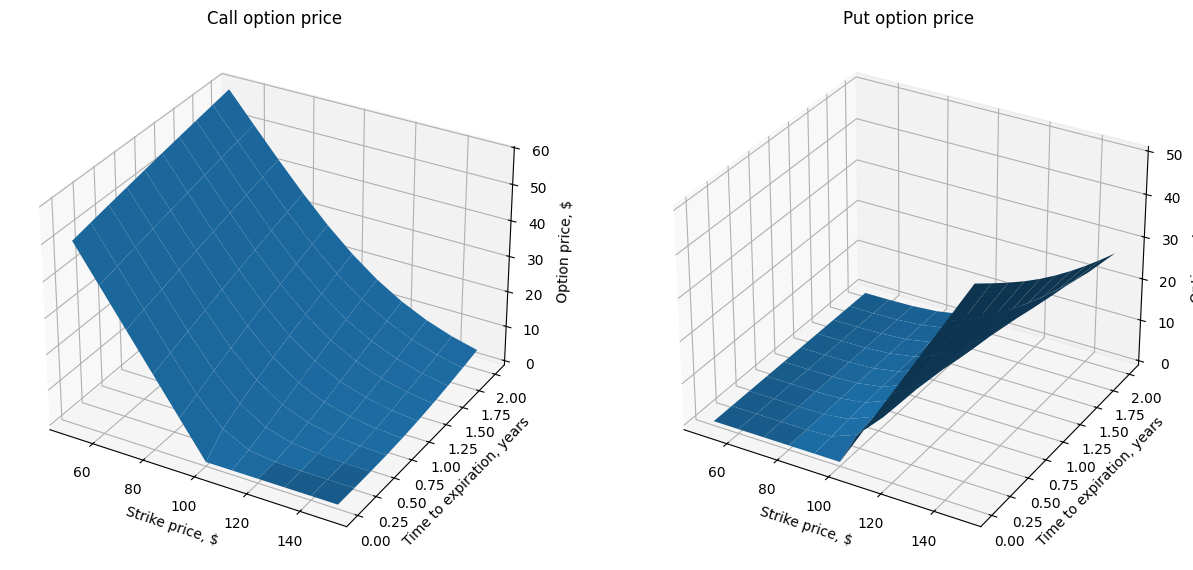

In [13]:
x, y = np.meshgrid(strikes, times)
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

plt.show()

In [14]:
def plot_all(type_: str = 'Call',
             time_to_expiration: float = 0.25,
             volatility: float = 0.1587,
             stock_price: float = 100.0,
             interest_rate: float = 0.0):
    opt = StockOption(strike_price=np.linspace(20, 200, 100),
                      expiration_time=time_to_expiration,
                      is_call=(type_ == 'Call'))
    ms = MarketState(stock_price=stock_price,
                        interest_rate=interest_rate)
    params = BSParams(volatility=volatility)
    
    data = {
        'price': price(opt, ms, params),
        'delta': delta(opt, ms, params),
        'gamma': gamma(opt, ms, params),
        'vega': vega(opt, ms, params),
        'theta': theta(opt, ms, params),
        'rho': rho(opt, ms, params)
    }

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    for (name, vals), ax in zip(data.items(), axs.flatten()):
        ax.plot(opt.strike_price, vals)
        ax.set_title(name)
        ax.set_xlabel('Strike price')
        
    plt.show()

In [15]:
interact(plot_all,
         type_=widgets.Dropdown(options=['Call', 'Put'], value='Call', description='Option type'),
         time_to_expiration=widgets.FloatSlider(min=0.01, max=5.0, step=0.01, value=0.25, description='Time to expiration, years'),
         volatility=widgets.FloatSlider(min=0.1, max=2.0, step=0.01, value=0.1587, description='Volatility, annualized'),
         stock_price=widgets.FloatSlider(min=50.0, max=150.0, value=100.0, description='Stock price'),
         interest_rate=widgets.FloatSlider(min=0, max=0.2, step=0.005, value=0.0, description='Interest rate, annualized'));

interactive(children=(Dropdown(description='Option type', options=('Call', 'Put'), value='Call'), FloatSlider(…

## IV 

In [16]:
#c помощью метода касательных находим сигму

def fit_params(option: CallStockOption, ms: MarketState, option_price: float) -> BSParams:
    
    RTOL = 1e-6
    VOL_MIN = 0.0
    VOL_MAX = 10.0
    MAX_ITER = 100
    
    s = deepcopy(ms)
    vol = 0.2

    lb = VOL_MIN
    rb = VOL_MAX
    
    for i in range(MAX_ITER):
        
        params = BSParams(vol)
        p = price(option, s, params)
        resid = p - option_price
        if abs(resid) / option_price < RTOL:
            break
        
        # try Newton step if vega is not zero
        v = vega(option, s, params)
        if v > 0 and not np.isclose(v, 0):
            new_vol = vol - (p - option_price) / v
        else:
            new_vol = np.nan

        # if something went wrong, bisect
        if np.isnan(new_vol) or new_vol < lb or new_vol > rb:
            new_vol = (lb + rb) / 2

        params = BSParams(new_vol)
        new_p = price(option, s, params)

        if new_p > option_price:
            rb = new_vol
        else:
            lb = new_vol
        
        vol = new_vol
        p = new_p
        
    return params

In [17]:
df = pd.read_csv("calls.csv")
df

,strike,price,yahoo_iv,stock_price,time_to_expiration
0,150.0,288.73,0.8307,430.78,0.83
1,160.0,278.77,0.7858,430.78,0.83
2,190.0,242.60,0.5232,430.78,0.83
3,200.0,232.63,0.4950,430.78,0.83
4,250.0,183.87,0.4016,430.78,0.83
...,...,...,...,...,...
86,550.0,1.34,0.1594,430.78,0.83
87,560.0,1.02,0.1601,430.78,0.83
88,565.0,0.89,0.1605,430.78,0.83
89,600.0,0.42,0.1681,430.78,0.83


In [18]:
market_state = MarketState(stock_price=df.at[0, "stock_price"], interest_rate=0.0)
for idx, row in df.iterrows():
    option = CallStockOption(strike_price=row["strike"],
                             expiration_time=row["time_to_expiration"])
    df.at[idx, "iv"] = fit_params(option, market_state, row["price"]).volatility

Mean squared error: 0.00004


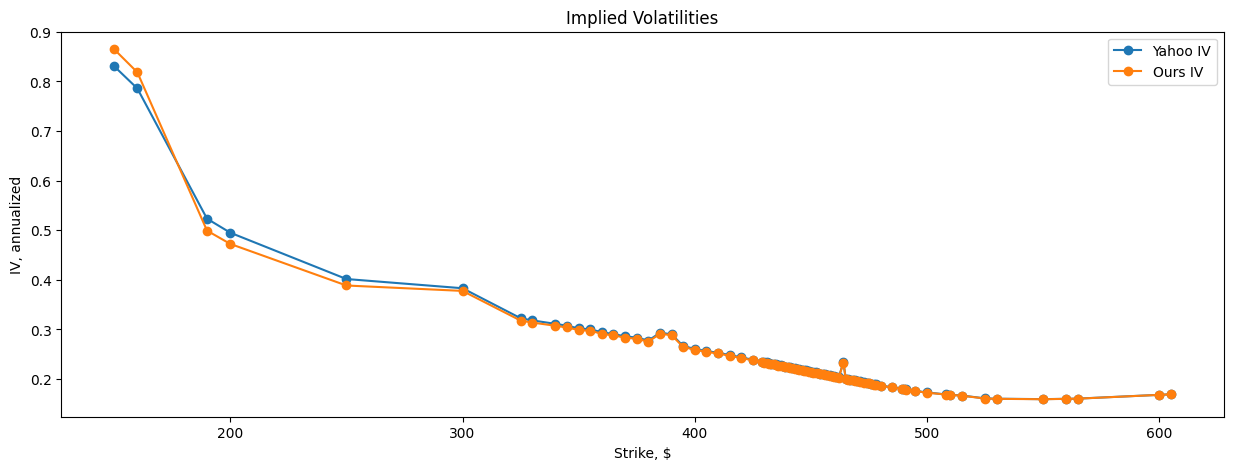

In [19]:
_, ax = plt.subplots(figsize=(15, 5))

print("Mean squared error: {:.5f}".format(np.mean((df["iv"] - df["yahoo_iv"])**2)))

ax.plot(df["strike"], df["yahoo_iv"], "o-", label="Yahoo IV")
ax.plot(df["strike"], df["iv"], "o-", label="Ours IV")
ax.legend()
ax.set_xlabel("Strike, $")
ax.set_ylabel("IV, annualized")
ax.set_title("Implied Volatilities")
plt.show()

In [22]:
import py_vollib.black_scholes.implied_volatility as iv

In [23]:
option = CallStockOption(strike_price=100.0, expiration_time=1.0)
ms = MarketState(stock_price=100.0, interest_rate=0.1)
params = BSParams(volatility=0.167)

In [24]:
call_price = price(option, ms, params)
call_price

array(12.19590432)

In [31]:
#%%timeit   #гоняет много раз и вычисляет время работы функции

fit_params(option, ms, call_price)

BSParams(volatility=np.float64(0.16700000000041504))

In [30]:
#%%timeit

iv.implied_volatility(
    call_price,
    ms.stock_price,
    option.strike_price,
    option.expiration_time - ms.time,
    ms.interest_rate,
    "c",
)

0.16699999999999993

## Simulating 

In [33]:
def make_bsm_market_simulator(
    ms: MarketState,
    params: BSParams,
    time_stop: float,
    n_steps: int = 200,
):
    
    def simulate(n_paths: int, seed: int = 0xB0BA_C_3AB0DA):
        dt = (time_stop - ms.time) / n_steps
        random = np.random.default_rng(seed)
        norm = random.normal(size=(n_paths, n_steps))
        d_log_s = (
            (ms.interest_rate - params.volatility ** 2 / 2) * dt
            + params.volatility * norm * np.sqrt(dt)
        )
        d_log_s = np.insert(d_log_s, 0, np.zeros(n_paths), axis=1)
        return ms.stock_price * np.exp(np.cumsum(d_log_s, axis=-1))
    
    return simulate

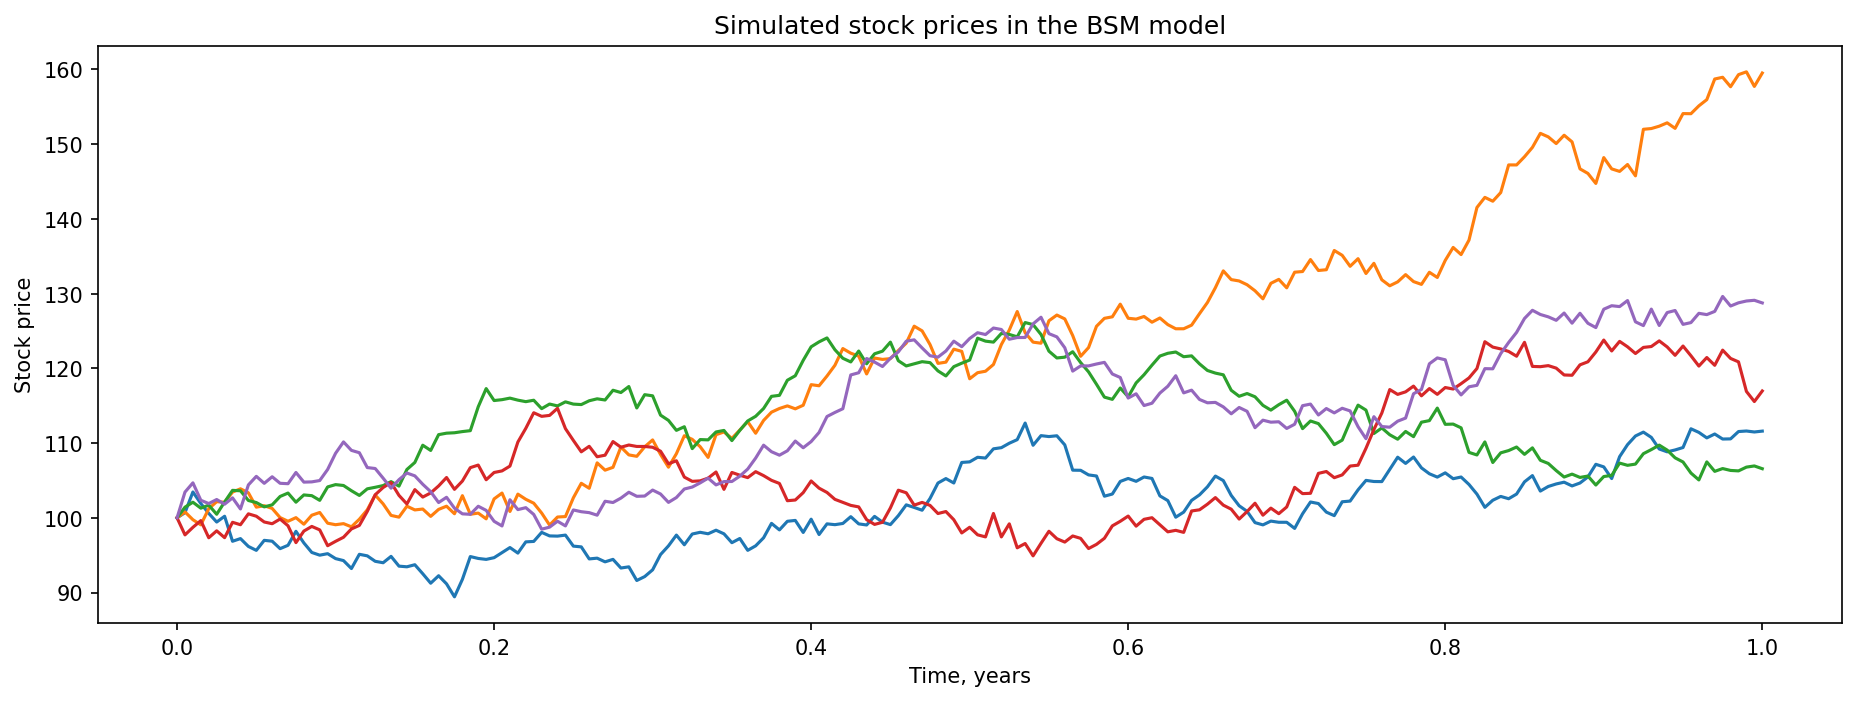

In [34]:
N = 5
STEPS = 200
T = 1.0

ms = MarketState(stock_price=100, interest_rate=0.1)
params = BSParams(volatility=0.167)
sim_fn = make_bsm_market_simulator(ms, params, T, STEPS)
paths = sim_fn(N)
t = np.linspace(0, T, STEPS + 1)

_, ax = plt.subplots(figsize=(15, 5), dpi=150)
ax.plot(t, paths.T)
ax.set_xlabel("Time, years")
ax.set_ylabel("Stock price")
ax.set_title("Simulated stock prices in the BSM model")
plt.show()

## Hedging

In [35]:
def calc_hedging_pnl(
    option: StockOption,
    ms: MarketState,
    params: BSParams,
    n_steps: int = 200,
    n_paths: int = 1000,
    seed: int = 0xB0BA_C_3AB0DA,
):
    sim_fn = make_bsm_market_simulator(ms, params, option.expiration_time, n_steps)
    paths = sim_fn(n_paths, seed)                                            # paths.shape == (n_paths, n_steps + 1)
    times = np.linspace(ms.time, option.expiration_time, n_steps + 1)[None]  # times.shape == (1,       n_steps + 1), numpy broadcasting rules
    bank_acc = 1.0 * np.exp(ms.interest_rate * (times - times[:, 0]))
    df = 1.0 / bank_acc
    
    inter_ms = MarketState(
        stock_price=paths,
        interest_rate=ms.interest_rate,
        time=times,
    )
        
    opt_p = price(option, inter_ms, params)
    stock_pos = delta(option, inter_ms, params)
    bank_acc_pos = df * (opt_p - stock_pos * paths)
    hedging_pnl = (
        stock_pos[:, :-1] * np.diff(paths, axis=-1)
        + bank_acc_pos[:, :-1] * np.diff(bank_acc, axis=-1)
    )
    payoff = -option.payoff(paths[:, [-1]])
    return np.append(hedging_pnl, payoff, axis=-1)

In [36]:
option = CallStockOption(strike_price=100.0, expiration_time=1.0)
ms = MarketState(stock_price=100.0, interest_rate=0.1)
params = BSParams(volatility=0.167)

In [37]:
p = price(option, ms, params)
p

array(12.19590432)

In [38]:
pl = -calc_hedging_pnl(
    option,
    ms,
    params,
    n_paths=1000,
    n_steps=2000,
    seed=1,
).sum(-1)

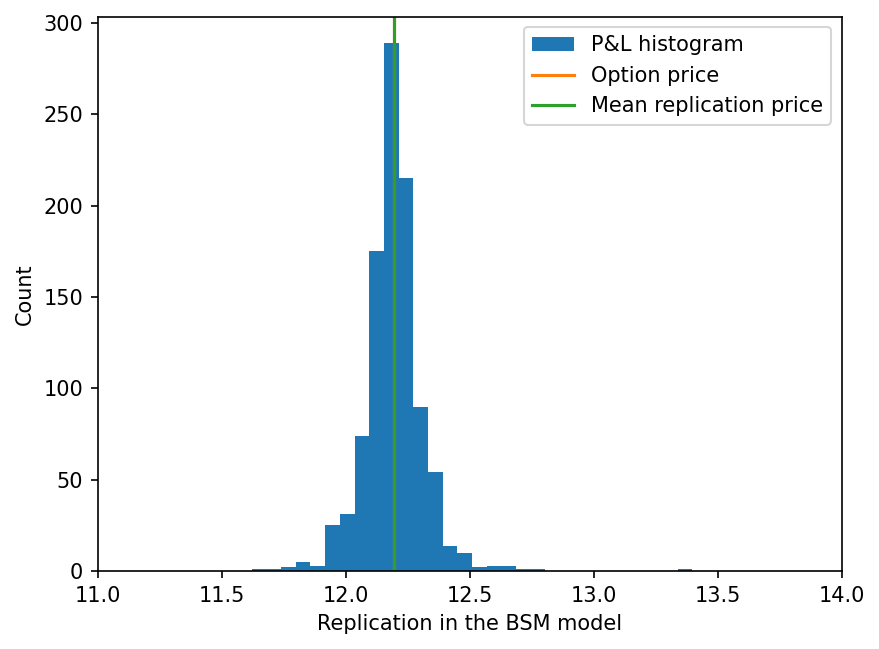

In [39]:
_, ax = plt.subplots(dpi=150)
ax.hist(pl, bins=30, label="P&L histogram")
ax.axvline(p, c="C1", label="Option price")
ax.axvline(pl.mean(), c="C2", label="Mean replication price")
ax.set_xlabel("Replication in the BSM model")
ax.set_ylabel("Count")
ax.set_xlim(11, 14)
ax.legend()
plt.show()

## Black formula VS Black-Scholes formula

The Black-Scholes formula is too simplistic for practical usage, and we don't talk about the GBM inside.
The other problems are:
- How to calculate year fraction (day count convention)?
- What if the rates are stochastic?
- What if the stock pays dividends?

Consider the **forwaard contract** written on the underlying with the same expiration date as an option's.
The Black formula reads:
$$
V^{\text{call}} = DF_{t,T}\bigl(F_{t,T}\Phi(d_+) - K\Phi(d_-)), \quad
V^{\text{put}} = DF_{t,T}\bigl(K\Phi(-d_-) -F_{t,T}\Phi(-d_+)\bigr),
$$
where $\Phi(x)$ is the standard normal cumulative distribution function, and
$$
d_+ = \frac{1}{\sigma\sqrt{(T - t)}} \biggl(\ln\frac{F_{t,T}}{K} 
  + \frac{\sigma^2}{2} (T - t)\biggr), \qquad 
d_- = \frac{1}{\sigma\sqrt{(T - t)}} \biggl(\ln\frac{F_{t,T}}{K} 
  -\frac{\sigma^2}{2} (T - t)\biggr).
$$

$DF_{t,T}$ is a **discount factor**, a price of a zero-coupon bond at time $t$ that matures at $T$.
So we now can split the stock model and the rates model and just «ask» the rates model about zero-coupon bonds prices
In the simplet case of constant rate and no dividentds $F_{t,T} = e^{r(T - t)}S$ and $DF_{t,T} = e^{-r(T - t)}$. Substituting these in the Black formula we obtain the familiar Black-Scholes formula mentioned above.

**Practitioners always uses the Black formula.**